In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE,
  CC_DAYS_TO_ADD,
  TERMS_OF_PAYMENT_KEY  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
    AND ("2024-01-01" >=PAYMENT_DATE)
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [6]:
df.query('ENTERPRISE_ACCOUNT_NO == "7100007382"').CREDIT_CONTROL_AREA.unique()

array(['PD', 'PRMD'], dtype=object)

In [7]:
df.ENTERPRISE_ACCOUNT_NO.value_counts()

7100007382    12010976
               9365686
7100017882     3147195
7100002977     3010252
7100000361     1375177
                ...   
7100008084           1
7100021081           1
7100024115           1
7100007256           1
7100020510           1
Name: ENTERPRISE_ACCOUNT_NO, Length: 7705, dtype: int64

In [8]:
# df['PAYMENT_DATE']=pd.to_datetime(df['PAYMENT_DATE'])
# df.query('"2024-01-01" >=PAYMENT_DATE')

In [9]:
df=df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
df['CC_DAYS_TO_ADD']=df['CC_DAYS_TO_ADD'].apply(lambda x: float(x))
df['AMOUNT_IN_LOCAL_CURRENCY']=df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
df.reset_index(inplace = True)


In [10]:
def calc_WAPD(df_1):
    df_1['PAYMENT_DATE']=pd.to_datetime(df_1['PAYMENT_DATE'])
    df_1['DOCUMENT_DATE_IN_DOCUMENT']=pd.to_datetime(df_1['DOCUMENT_DATE_IN_DOCUMENT'])
    WAPD_new = pd.Series([])
    for index, row in df_1.iterrows():
        start_date= row['PAYMENT_DATE']
        end_date = row['90_days_ago']
        try:
            ninety_day_range = df_1.query('@start_date >= DOCUMENT_DATE_IN_DOCUMENT   >= @end_date')
            WAPD= ninety_day_range['Weighted Invoice Value'].sum() / ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
            WAPD_new[index]=WAPD
        except:
            print('no PAYMENT_DATE')
    df_1.insert(16, "WAPD", WAPD_new)
    return df_1

In [11]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    CUSTOMER_df.reset_index(inplace = True)
    
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    return CUSTOMER_df

In [12]:
# Returns a tuple of DataFrames sorted by DSO term

def get_terms(ENTERPRISE_ACCOUNT_NO):
    return_list = []
    
    terms_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    
    # terms_df.reset_index(inplace = True)
    terms_list = terms_df['CC_DAYS_TO_ADD'].unique()
    print(terms_list)
    
    for dso_term in terms_list:
        name = str(dso_term)+"_term"
        name = terms_df.query('CC_DAYS_TO_ADD ==@dso_term')
        return_list.append(name)
    
    return return_list
 
# EAN = "7100000391"
# s = get_terms(EAN)

In [13]:
def search_EAN(CUSTOMER_df):
    # CUSTOMER_df=EN_df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    CUSTOMER_df.reset_index(inplace = True)
   
    # CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    
    
    
    return CUSTOMER_df

In [14]:
def search_EAN_terms(ENTERPRISE_ACCOUNT_NO):
    CUSTOMER_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    CUSTOMER_df.reset_index(inplace = True)
    
#     loop for terms 

    four = CUSTOMER_df.query('CC_DAYS_TO_ADD ==4.000000000')
    thirty =CUSTOMER_df.query('CC_DAYS_TO_ADD ==30.000000000')
    sixty =CUSTOMER_df.query('CC_DAYS_TO_ADD ==60.000000000')
    ninty = CUSTOMER_df.query('CC_DAYS_TO_ADD ==90.000000000')

# FOUR



    four['AMOUNT_IN_LOCAL_CURRENCY']=four['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    four['Sub Payment Date from Invoice Date']=(four['PAYMENT_DATE']-four['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    four['Weighted Invoice Value']= four['Sub Payment Date from Invoice Date']*four['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(four['PAYMENT_DATE'])
    four['90_days_ago']= current - pd.to_timedelta('90 days')
    four = calc_WAPD(four)
    
#   THIRTY  
    
    thirty['AMOUNT_IN_LOCAL_CURRENCY']=thirty['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    thirty['Sub Payment Date from Invoice Date']=(thirty['PAYMENT_DATE']-thirty['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    thirty['Weighted Invoice Value']= thirty['Sub Payment Date from Invoice Date']*thirty['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(thirty['PAYMENT_DATE'])
    thirty['90_days_ago']= current - pd.to_timedelta('90 days')
    thirty = calc_WAPD(thirty)
    
    
    
    
    return CUSTOMER_df

# **********************************************************************************************************

# Visualization

## Customer

In [15]:
customer = "2057194397"
t = search_customer(customer)

In [16]:
t.tail()

,level_0,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,TERMS_OF_PAYMENT_KEY,WAPD,Sub Payment Date from Invoice Date,Weighted Invoice Value,90_days_ago
573,42146754,50072189,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-24,ZF,01 - Invoice,3232.3800,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,29,93739.0200,2023-06-24
574,42146810,50072259,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-23,ZF,01 - Invoice,2251.5600,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,30,67546.8000,2023-06-24
575,42147145,50072641,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-24,ZF,01 - Invoice,497.3700,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,29,14423.7300,2023-06-24
576,42147915,50073523,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-21,ZF,01 - Invoice,2481.2800,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,32,79400.9600,2023-06-24
577,42148352,50074029,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-25,ZF,01 - Invoice,608.5000,PD,CLEAR,2023-09-22,28.0000,YS28,28.6444,28,17038.0000,2023-06-24


In [17]:
t['month'] = t['PAYMENT_DATE'].dt.strftime('%b')

In [18]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

dfp1 = pd.pivot_table(data=t, index=[t.PAYMENT_DATE.dt.year,t.CREDIT_CONTROL_AREA], columns='month', values='WAPD')
dfp1 = dfp1.reindex(year_order, axis=1)
dfp1

,month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,CREDIT_CONTROL_AREA,,,,,,,,,,,,
2022,PD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9744,29.9637,29.9682,30.0434
2023,PD,29.7159,28.5953,25.1921,24.8993,24.3104,25.7423,25.0257,26.6483,27.9685,NaN,NaN,NaN


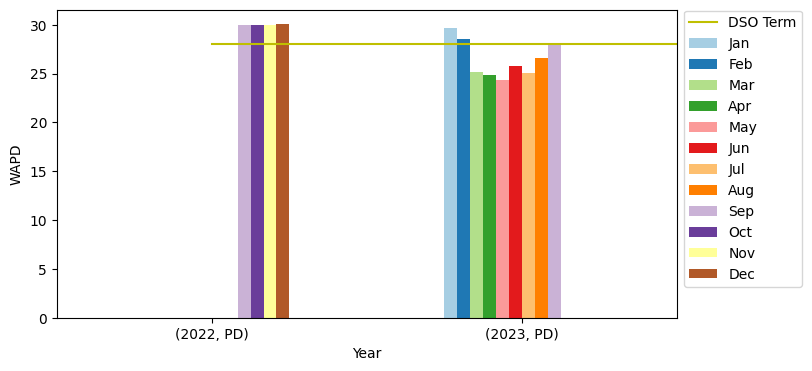

In [19]:
ax = dfp1.plot(kind='bar', figsize=(8, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax.plot(t.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

## EAN

In [21]:
EAN = "7100007382"
s = get_terms(EAN)
# DSO terms are printed below

[ 15.  65.  75.  60.  90.  30.  32.  29.  31.   7.  35.  26.  59.  61.
  33. 120.   0.  34.  40.  28.  27.  37.  39.  36.  10.  38.   5.   8.]


In [22]:
s[5].CREDIT_CONTROL_AREA.unique()

array(['PD', 'PRMD'], dtype=object)

In [23]:
fi=search_EAN(s[5])

In [26]:
fi['month'] = fi['PAYMENT_DATE'].dt.strftime('%b')

In [173]:
df_final = pd.DataFrame({'Year': fi.PAYMENT_DATE.dt.year,
                   'Month': fi.month,
                   'CREDIT_CONTROL_AREA': fi.CREDIT_CONTROL_AREA,
                   'WAPD':fi.WAPD})

In [29]:
monthly = df_final.groupby(['Year','CREDIT_CONTROL_AREA','Month'])['WAPD'].mean()
# year_order = ['Jan','Feb',||year_order, axis=1)

In [276]:
exp_cash_flow_grp = (
    df_final
    .filter(["Year", "Month","CREDIT_CONTROL_AREA","WAPD"])
    # .query('DOCUMENT_TYPE in ("DH", "DL", "DZ", "DW", "DC")')
    .groupby(['Year','Month','CREDIT_CONTROL_AREA'])
    .agg({'WAPD' : ['mean']})
    .sort_values(['Year',"Month"])
    .reset_index()
)
exp_cash_flow_grp.columns = ['Year','Month', 'CREDIT_CONTROL_AREA','WAPD']

In [293]:
df["period"] =df["Month"] +"\n"+  df["Year"].astype(str)

In [294]:
df=exp_cash_flow_grp
df.period.unique()

array(['Aug\n2022', 'Dec\n2022', 'Nov\n2022', 'Oct\n2022', 'Sep\n2022',
       'Apr\n2023', 'Aug\n2023', 'Feb\n2023', 'Jan\n2023', 'Jul\n2023',
       'Jun\n2023', 'Mar\n2023', 'May\n2023', 'Sep\n2023'], dtype=object)

In [297]:
# 0 = [2022, 2023]
fruits = ['Aug\n2022', 'Dec\n2022', 'Nov\n2022', 'Oct\n2022', 'Sep\n2022',
       'Apr\n2023', 'Aug\n2023', 'Feb\n2023', 'Jan\n2023', 'Jul\n2023',
       'Jun\n2023', 'Mar\n2023', 'May\n2023', 'Sep\n2023']
years= ['PD', 'PRMD']
num_fruit = len(fruits)
num_years = len(years)
# num_CCA= len(CCA)

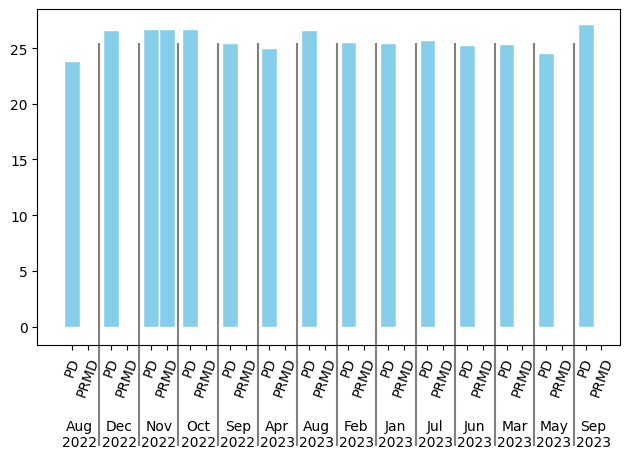

In [304]:
width = 0.8
for i, fruit in enumerate(fruits):
    # print(fruit) YEAR
    for j, year in enumerate(years):
        # print(year) MONTH
        
        plt.bar(i + width / num_years * (j - (num_years - 1) / 2),
                df[(df['period'] == fruit) & (df['CREDIT_CONTROL_AREA'] == year)]['WAPD'],
                width / num_years, color='skyblue', ec='white')
plt.xticks([i + width / num_years * (j - (num_years - 1) /2) 
            for i in range(num_fruit) for j in range(num_years)],
           np.tile(years, num_fruit), rotation=70)
    
# plt.figure(figsize=(300,6))
ax = plt.gca()
# ax.yaxis.set_major_locator(MultipleLocator(1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.2))
# ax.grid(True, axis='y')
# ax.autoscale(False, axis='y')
trans = blended_transform_factory(ax.transData, ax.transAxes)
# plt.plot(fi.CC_DAYS_TO_ADD)
for i, fruit in enumerate(fruits):
    ax.text(i, -0.3, fruit, transform=trans, ha='center')
    if i != 0:
        ax.vlines(i - 0.5, .9, -0.3, color='gray', clip_on=False, transform=trans)
plt.tight_layout()
# print(df)
# figure(figsize=(8, 6), dpi=80)
plt.show()

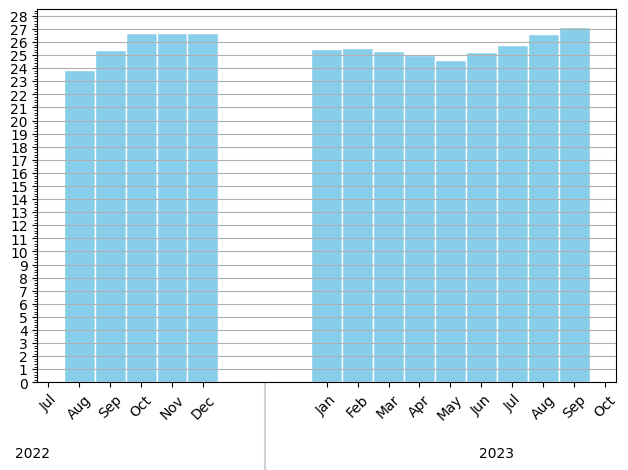

In [218]:
width = 0.8
for i, fruit in enumerate(fruits):
    # print(fruit) YEAR
    for j, year in enumerate(years):
        # print(year) MONTH
        plt.bar(i + width / num_years * (j - (num_years - 1) / 2),
                df[(df['Year'] == fruit) & (df['Month'] == year)]['WAPD'],
                width / num_years, color='skyblue', ec='white')
plt.xticks([i + width / num_years * (j - (num_years - 1) / 2) 
            for i in range(num_fruit) for j in range(num_years)],
           np.tile(years, num_fruit), rotation=45)
# plt.figure(figsize=(300,6))
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.grid(True, axis='y')
ax.autoscale(False, axis='y')
trans = blended_transform_factory(ax.transData, ax.transAxes)
for i, fruit in enumerate(fruits):
    ax.text(i, -0.2, fruit, transform=trans, ha='center')
    if i != 0:
        ax.vlines(i - 0.5, 0, -0.3, color='lightgrey', clip_on=False, transform=trans)
plt.tight_layout()
# print(df)
# figure(figsize=(8, 6), dpi=80)
plt.show()

           fruit  year  value
0         apples  2015      5
1          pears  2015      1
2     nectarines  2015      2
3          plums  2015      6
4         grapes  2015      7
5   strawberries  2015      1
6         apples  2016      7
7          pears  2016      7
8     nectarines  2016      4
9          plums  2016      2
10        grapes  2016      7
11  strawberries  2016      3
12        apples  2017      3
13         pears  2017      1
14    nectarines  2017      2
15         plums  2017      4
16        grapes  2017      1
17  strawberries  2017      6


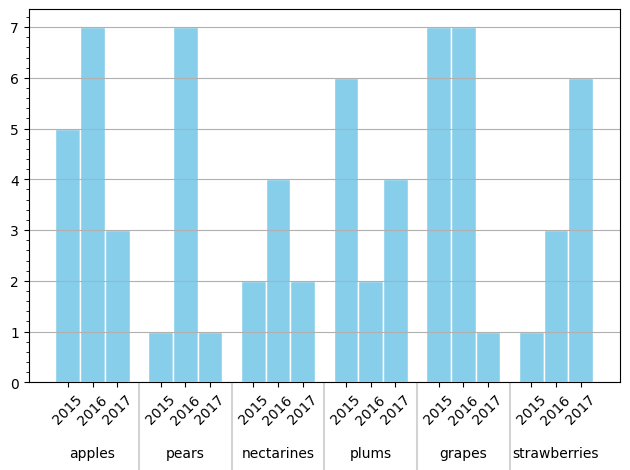

In [167]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import seaborn as sns

fruits = ['apples', 'pears', 'nectarines', 'plums', 'grapes', 'strawberries']
years = [2015, 2016, 2017]
num_fruit = len(fruits)
num_years = len(years)
df = pd.DataFrame({'fruit': np.tile(fruits, num_years),
                   'year': np.repeat(years, num_fruit),
                   'value': np.random.randint(1, 8, num_fruit * num_years)})

width = 0.8
for i, fruit in enumerate(fruits):
    for j, year in enumerate(years):
        plt.bar(i + width / num_years * (j - (num_years - 1) / 2),
                df[(df['fruit'] == fruit) & (df['year'] == year)]['value'],
                width / num_years, color='skyblue', ec='white')
plt.xticks([i + width / num_years * (j - (num_years - 1) / 2) for i in range(num_fruit) for j in range(num_years)],
           np.tile(years, num_fruit), rotation=45)
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.grid(True, axis='y')
ax.autoscale(False, axis='y')
trans = blended_transform_factory(ax.transData, ax.transAxes)
for i, fruit in enumerate(fruits):
    ax.text(i, -0.2, fruit, transform=trans, ha='center')
    if i != 0:
        ax.vlines(i - 0.5, 0, -0.3, color='lightgrey', clip_on=False, transform=trans)
plt.tight_layout()
print(df)
plt.show()

In [ ]:
four=search_EAN(s[0])
thirty=search_EAN(s[1])
ninty=search_EAN(s[2])
sixty=search_EAN(s[3])



In [ ]:
four.CREDIT_CONTROL_AREA.unique()

In [ ]:
sixty

In [ ]:
four['month'] = four['PAYMENT_DATE'].dt.strftime('%b')
thirty['month'] = thirty['PAYMENT_DATE'].dt.strftime('%b')
sixty['month'] = sixty['PAYMENT_DATE'].dt.strftime('%b')
ninty['month'] = ninty['PAYMENT_DATE'].dt.strftime('%b')

In [ ]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_4 = pd.pivot_table(data=four, index=[four.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_4 = dfp_4.reindex(year_order, axis=1)
dfp_4

In [ ]:
four.query('month == "Sep"')[['AMOUNT_IN_LOCAL_CURRENCY','WAPD']].describe()

In [ ]:
dfp_4.plot(kind='bar', figsize=(8, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired',zorder=0)
plt.plot(four.CC_DAYS_TO_ADD, c = "y", label = "DSO Term",zorder=10)
_ = plt.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

In [ ]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_30 = pd.pivot_table(data=thirty, index=[thirty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_30 = dfp_30.reindex(year_order, axis=1)
dfp_30

In [ ]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_60 = pd.pivot_table(data=sixty, index=[sixty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_60 = dfp_60.reindex(year_order, axis=1)
dfp_60

In [ ]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_90 = pd.pivot_table(data=ninty, index=[ninty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_90 = dfp_90.reindex(year_order, axis=1)
dfp_90

In [ ]:
ax30 = dfp_30.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax30.plot(thirty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax30.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
ax60 = dfp_60.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax60.plot(sixty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax60.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
sixty.CC_DAYS_TO_ADD

In [ ]:
ax90 = dfp_90.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax90.plot(ninty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax90.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
 from pivottablejs import pivot_ui

In [ ]:
dfp_4

In [ ]:
pivot_ui(dfp_4)

## National Account